In [1]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from utils import get_nodule_class, filename_from_annotation, cluster_annots

c:\Users\Daniela\Desktop\Fac\3ºano\Lab_IACD\Project1\lung-cancer-classification\utils.py:18: SyntaxWarning: invalid escape sequence '\_'
  """


In [2]:
from PIL import Image
from gtts import gTTS
from pytesseract import image_to_string
from scipy.io.wavfile import write

from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import spectrogram

import pandas as pd
from collections import Counter
import bisect

import librosa
import librosa.display

import soundfile as sf
import io


In [3]:
MAX_NODULE_WIDTH = 47
MAX_NODULE_HEIGHT = 47
N_SLICES = 5

---
Get Masks and Cropped Images


### Normalization

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used thresholds are -1000 and 400.

**Warning**: Do not zero center with the mean per image. The CT scanners are calibrated to return accurate HU measurements.

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    
def normalize(image):
    # Scale
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.

    # Zero mean
    image = image - PIXEL_MEAN

    return image

In [74]:
def zoomout_nodule(bbox, width, height, n_slices):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].start - x_acres + width, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].start - y_acres + width, None)

    z_slice = np.linspace(bbox[2].start, bbox[2].stop, n_slices, endpoint=False, dtype=int)

    return (x_slice, y_slice, z_slice)

In [ ]:
def get_cropped_annot(scan: pl.Scan, nods, mask: bool=False):
    if len(scan.annotations) == 0:
        return None

    vol = scan.to_volume(verbose=False)

    # Normalize values
    vol = normalize(vol)

    images = []
    masks = []
    for anns in nods:
        cmask, cbbox, _ = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT, N_SLICES)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
nods = cluster_annots(scan)
cropped, _ = get_cropped_annot(scan, nods, True)

# Set up the plot.
for i in range(N_SLICES):
    plt.subplot(2, 3, i+1)
    plt.imshow(cropped[0][:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
malign_path = Path("data/images/malign")
belign_path = Path("data/images/belign")

os.makedirs(malign_path, exist_ok=True)
os.makedirs(belign_path, exist_ok=True)

scans = pl.query(pl.Scan).all()
for scan in scans:
    try:
        if len(scan.annotations) == 0:
            # Scan has no annotations, there is nothing to do
            continue

        nods = cluster_annots(scan)
        cropped, masks = get_cropped_annot(scan, nods, True)

        for i, anns in enumerate(nods):
            label = get_nodule_class(anns)
            if label == 0:
                continue
            
            filename = filename_from_annotation(anns[0])
            mask_filename = filename + "-mask"
            if label == 1:
                np.save(malign_path/filename, cropped[i].astype(np.float32))
                np.save(malign_path/mask_filename, masks[i].astype(np.float32))
            elif label == -1:
                np.save(belign_path/filename, cropped[i].astype(np.float32))
                np.save(belign_path/mask_filename, masks[i].astype(np.float32))


            # função do audio features dadas [id_paciente, id_anotação, ..info_som_..]
            l = [scan.patient_id(), nods[i][0].id]+ sound_def(cropped[i][:,:,2])    
            #sound_def encontra-se em baixo 
    except RuntimeError as e:
        print(e)

Couldn't find DICOM files for Scan(id=1,patient_id=LIDC-IDRI-0078) in ../dataset/LIDC-IDRI/LIDC-IDRI-0078
Couldn't find DICOM files for Scan(id=2,patient_id=LIDC-IDRI-0069) in ../dataset/LIDC-IDRI/LIDC-IDRI-0069
Couldn't find DICOM files for Scan(id=3,patient_id=LIDC-IDRI-0079) in ../dataset/LIDC-IDRI/LIDC-IDRI-0079
Couldn't find DICOM files for Scan(id=4,patient_id=LIDC-IDRI-0101) in ../dataset/LIDC-IDRI/LIDC-IDRI-0101
Couldn't find DICOM files for Scan(id=5,patient_id=LIDC-IDRI-0110) in ../dataset/LIDC-IDRI/LIDC-IDRI-0110
Couldn't find DICOM files for Scan(id=6,patient_id=LIDC-IDRI-0115) in ../dataset/LIDC-IDRI/LIDC-IDRI-0115
Couldn't find DICOM files for Scan(id=7,patient_id=LIDC-IDRI-0132) in ../dataset/LIDC-IDRI/LIDC-IDRI-0132
Couldn't find DICOM files for Scan(id=8,patient_id=LIDC-IDRI-0136) in ../dataset/LIDC-IDRI/LIDC-IDRI-0136
Couldn't find DICOM files for Scan(id=9,patient_id=LIDC-IDRI-0150) in ../dataset/LIDC-IDRI/LIDC-IDRI-0150
Couldn't find DICOM files for Scan(id=10,patie

max-min = 0.4325
% mais recorrente = 1.95
26.62 73.38


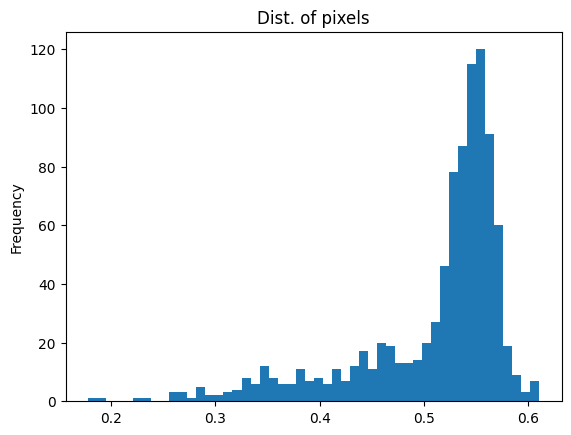

_________________


' \nintencidade                                               -> ver diff entre max e min\nfrequência                                                -> ver % do mais recorrente\nespectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) \ntempo do audio                                            -> diff entre a maior frequência e a menor (max-min)\nfrequência fundamental                                    -> o mais frequênte abaixo de 0.5\ntaxa de cruzamento por zero                               ->\nenergia                                                   ->\n'

In [59]:
#import base64 

image_data = cropped[0][:,:,2] 

x1, y1 = image_data.shape

x = x1//2
y = y1//2

'''
#print(x, y)
#print(image_data[x][y]) #image is array
#print(image_data.max()) #pixel com mais intencidade
#print(image_data.min()) #pixel com menor intencidade

pd.Series(image_data.flatten()).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()

list = []
for i in range(x1):
    for j in range(y1):
        if image_data[i][j]!=0:
            list.append(image_data[i][j])


'''


def find_first_greater(list, x, comp):
    # Use bisect_right to find the index where x would go to maintain sorted order
    index = bisect.bisect_right(list, x)
    
    # Check if the index is within the bounds of the list
    if index < comp: #len(list)
        return index  # This is the first instance where the number is greater than x
    else:
        return comp+1  # If no element is greater than x

def racist(img):
    x1, y1 = img.shape
    x = x1//2
    y = y1//2
    list = []
    #print(f"comp = {len(list)}")
    for i in range(x1):
        for j in range(y1):
            if image_data[i][j]!=0:
                list.append(float(image_data[i][j]))
    comp = len(list)

    #print(f"comp = {comp}")
    list = sorted(list)#, key=float

    #ver max diff
    print(f"max-min = {round(list[comp-1] - list[0],4)}")

    ''' 
    tentar div list em 50 diff catg
    '''

    counter = Counter(list)

    #ver % do mais recorrente
    print(f"% mais recorrente = {round(counter.most_common(1)[0][1]*100/comp,2)}")
     
    cinf = round((find_first_greater(list, 0.5, comp)-1)*100/comp,2)
    csup = round(100-cinf,2)
    print(cinf, csup)

    #most common zone
    #mcommon = round(bindario(list),2)
    #print(f"most common zone -> {mcommon}")

    return list


list = racist(image_data)
#print(list)

#for pixel-if != 0 -> traduzir para frequência


#print(type(list), type(image_data), type(image_data[0][0]), type(float(image_data[0][0])), type(list[0]))

pd.Series(list).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()


print('_________________')


# Your list of numbers (replace this with your actual data)
#numbers = [...]  # Replace this with your list

# Define the number of bins (50 bins)


def bindario(list):
    num_bins = 50

    bin_edges = np.linspace(min(list), max(list), num_bins + 1)

    binned_indices = np.digitize(list, bin_edges) - 1  #  Subtract 1 to make bins zero-based
    binned_indices = binned_indices[:-1]

    bins = [0 for _ in range(num_bins)]
    for num, bin_idx in zip(list, binned_indices):
        bins[bin_idx]+=1

    #print(type(bin_edges))
    #print(bin_edges)

    #find pos of max
    #print((bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins))+1])/2)

    return(bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins)) + 1])/2




#image_data = image_data.copy(order='C')

#converted_string = base64.b64encode(image_data) 
#print(converted_string)
 
  
#sound = gTTS(converted_string, lang="en")
#sound.save("sound.mp3")

''' 
intencidade                                               -> ver diff entre max e min
frequência                                                -> ver % do mais recorrente
espectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) 
tempo do audio                                            -> diff entre a maior frequência e a menor (max-min)
frequência fundamental                                    -> o mais frequênte abaixo de 0.5
taxa de cruzamento por zero                               ->
energia                                                   ->
'''


In [56]:
''' 
por imagem
converter em som
'''
image_data = cropped[0][:,:,2]  


def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    #img = Image.fromarray(image_data).convert('L')
    img_data = np.array(image_data)
    

    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255]  

    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    return audio_data, sample_rate


''' 
# Convert NumPy array to a Pillow Image
img = Image.fromarray(image_data).convert('L')

img_data = np.array(img)

# Normalize pixel values to a frequency range (e.g., 20 Hz to 20,000 Hz)
min_freq = 20      # Minimum frequency (Hz)
max_freq = 20000   # Maximum frequency (Hz)

# Normalize the pixel intensities to the frequency range
frequencies = np.interp(img_data, [0, 255], [min_freq, max_freq])

# Generate a sine wave for each pixel
sample_rate = 44100  # Standard sampling rate for audio (Hz)
duration = 0.01      # Duration of each pixel's sound (seconds)

# Create an audio array by stacking sine waves
audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

# Normalize the audio data
audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

x1, y1 = image_data.shape
    x = x1//2
    y = y1//2
    print(image_data[x][y])
    print(img_data[x][y])


# Save the result as a WAV file
#write("image_to_sound.wav", sample_rate, audio_data)
'''



def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


ad, sr = convert_to_sound(image_data)


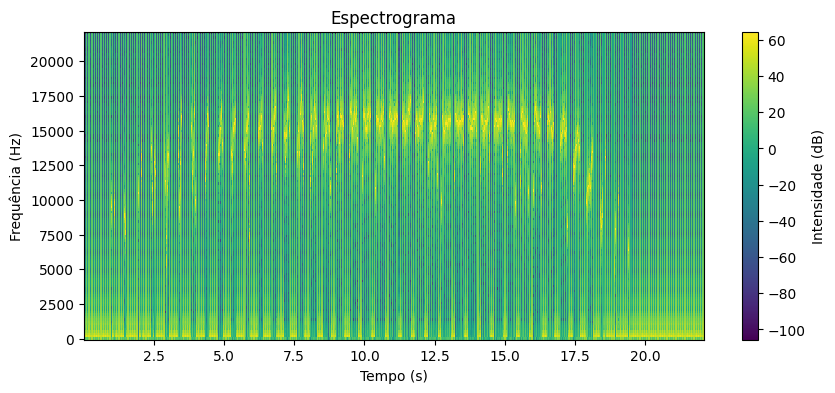

In [21]:
''' 
intencidade
frequência 
espectograma(variação das frequências)
tempo do audio
frequência fundamental
taxa de cruzamento por zero
energia
'''


#criar lista com as infos [duration, frequência fundamental, taxa de cruzamento por zero, energia]

duration = len(ad) / sr


# Análise 3: Espectrograma (Domínio da Frequência ao Longo do Tempo)
frequencies, times, Sxx = spectrogram(ad, sr)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

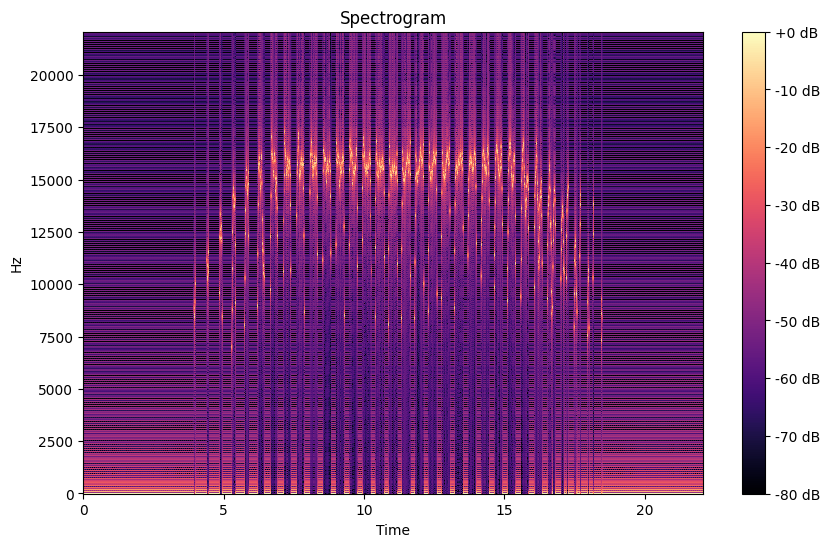

' \nintensidade\nfrequência \nespectograma(variação das frequências)\ntempo do audio\nfrequência fundamental\ntaxa de cruzamento por zero\nenergia\n'

In [52]:

def ver_specto(audio_data, sample_rate):
    # Check if the audio data is integer type
    if np.issubdtype(audio_data.dtype, np.integer):
        # Normalize the audio data to float32 in the range [-1, 1]
        audio_data = audio_data / np.max(np.abs(audio_data), axis=0)

    S = librosa.stft(audio_data)  # Short-time Fourier transform
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibel scale

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()
    return

ver_specto(ad, sr)


In [58]:
#ZCR
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

zcr = zero_crossing_rate(ad)
#print(f'Zero Crossing Rate: {zcr:.2f}')


# Calcular a intensidade (amplitude)
#intensidade média
def int_per_med(audio_data):
    int_per  = np.abs(audio_data)
    s = c = max = 0
    for i in int_per:
        if i!= 0:
            if i>max: max = i
            s += i
            c += 1
    
    
    return  round(s/c, 2), max

int_med, int_max = int_per_med(ad)
print(f"int_med = {int_med}, int_max = {int_max}")

# Energia
energia_total = np.sum(ad ** 2)
print(f"energia total = {energia_total}")



def frequencia_fundamental(audio_data):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0
    
    return ff


ff = round(frequencia_fundamental(ad),2)
print(f'Frequência Fundamental: {ff} Hz')


''' 
notas 
->descobrir o q intencidade 
->ver relevância de duração
->normalizar energia total e frequência fundamental
Gradient/movement (smooth vs. sharp transitions)
'''

C:\Users\Daniela\AppData\Local\Temp\ipykernel_22848\2182478874.py:24: RuntimeWarning: overflow encountered in scalar add
  s += i


int_med = 1541.53, int_max = 32767
energia total = 122265263
<class 'numpy.ndarray'> <class 'int'>
Frequência Fundamental: 57.37 Hz


' \nnotas \n->descobrir o q intencidade \n->ver relevância de duração\n->normalizar energia total e frequência fundamental\n'

In [7]:
''' 
função para extrair cenas do som
return lista 
'''

def sound_def(image_data):
    ad, sr = convert_to_sound(image_data)
    int_med, int_max = int_per_med(ad)
    #[ZCR, intencidade média, intensidade máxima, energia total, frequência fundamental]
    list = [((ad[:-1] * ad[1:]) < 0).sum() / len(ad), int_med, int_max, np.sum(ad ** 2),frequencia_fundamental(ad)]
    ''' 
    int_med = 1541.53, int_max = 32767
    energia total = 122265263
    Frequência Fundamental: 57.37 Hz
    '''
    return list




def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    #img = Image.fromarray(image_data).convert('L')
    img_data = np.array(image_data)
    

    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255]  

    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    return audio_data, sample_rate




def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


######################

#ZCR
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

#zcr = zero_crossing_rate(ad)
#print(f'Zero Crossing Rate: {zcr:.2f}')


# Calcular a intensidade (amplitude)
#intensidade média
def int_per_med(audio_data):
    int_per  = np.abs(audio_data)
    s = c = max = 0
    for i in int_per:
        if i!= 0:
            if i>max: max = i
            s += i
            c += 1
    
    
    return  round(s/c, 2), max

#int_med, int_max = int_per_med(ad)
#print(f"int_med = {int_med}, int_max = {int_max}")

# Energia
#energia_total = np.sum(ad ** 2)
#print(f"energia total = {energia_total}")



def frequencia_fundamental(audio_data):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0
    
    return round(ff,2)



image_data = cropped[0][:,:,2]  
list = sound_def(image_data)
for i in list:
    print(i)


C:\Users\Daniela\AppData\Local\Temp\ipykernel_15060\1298717573.py:70: RuntimeWarning: overflow encountered in scalar add
  s += i


0.5106229001333444
1541.53
32767
122265263
57.37
